# Phase estimation with QCNN
## States preparation

In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
##############


In [2]:
from qfuncs import *

In [3]:
N = 8
shots = 1000

dev = qml.device('default.qubit', wires=N, shots=shots)
H = qml_build_H(N, 0, 0)
@qml.qnode(dev)
def vqe_cost_fn(param):
    vqe_ising_chain_circuit(param, N)
    # return <psi|H|psi>
    return qml.expval(H)

In [4]:
drawer = qml.draw(vqe_cost_fn)
print(drawer(np.array([0]*(2*N))))

0: ──RY(0.00)─╭C────────────────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)─╰X─╭C─────────────────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)────╰X─╭C──────────────||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)───────╰X─╭C───────────||──RY(0.00)─┤ ├<𝓗>
4: ──RY(0.00)──────────╰X─╭C────────||──RY(0.00)─┤ ├<𝓗>
5: ──RY(0.00)─────────────╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
6: ──RY(0.00)────────────────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
7: ──RY(0.00)───────────────────╰X──||──RY(0.00)─┤ ╰<𝓗>


***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 600 (Max epochs for each lambda)
N         = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)─╭C────────────────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)─╰X─╭C─────────────────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)────╰X─╭C──────────────||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)───────╰X─╭C───────────||──RY(0.00)─┤ ├<𝓗>
4: ──RY(0.00)──────────╰X─╭C────────||──RY(0.00)─┤ ├<𝓗>
5: ──RY(0.00)─────────────╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
6: ──RY(0.00)────────────────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
7: ──RY(0.00)───────────────────╰X──||──RY(0.00)─┤ ╰<𝓗>


  0%|          | 0/25 [00:00<?, ?it/s]

/home/saverio/anaconda3/envs/qc/lib/python3.7/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  UserWarning,


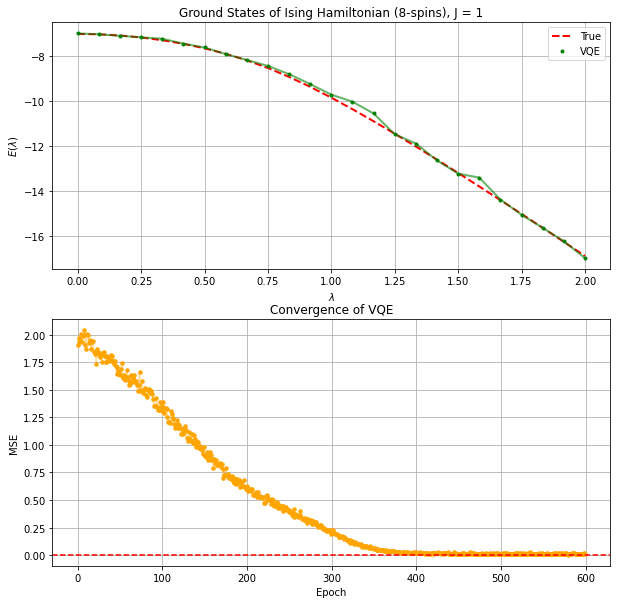

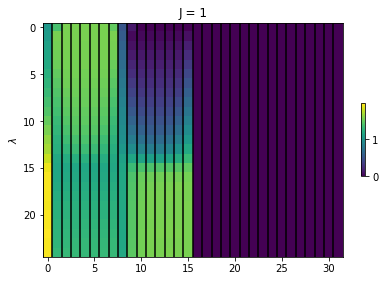

***Parameters:***

step_size = 0.01 (Step size of the optimizer)
epochs    = 600 (Max epochs for each lambda)
N         = 8 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)─╭C────────────────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)─╰X─╭C─────────────────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)────╰X─╭C──────────────||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)───────╰X─╭C───────────||──RY(0.00)─┤ ├<𝓗>
4: ──RY(0.00)──────────╰X─╭C────────||──RY(0.00)─┤ ├<𝓗>
5: ──RY(0.00)─────────────╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
6: ──RY(0.00)────────────────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
7: ──RY(0.00)───────────────────╰X──||──RY(0.00)─┤ ╰<𝓗>


  0%|          | 0/25 [00:00<?, ?it/s]

/home/saverio/anaconda3/envs/qc/lib/python3.7/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  UserWarning,


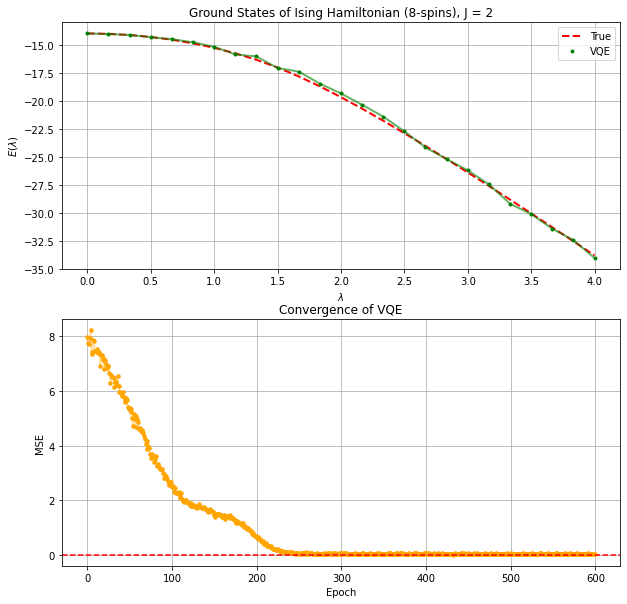

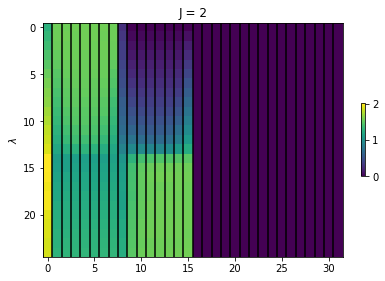

['./params.job']

In [5]:
thetas_arr = []

for J in [1,2]:
    vqe_e, errs, thetas, ys = train_vqe_ising(0.01, 25, 600, N, J, dev, circuit = True, plots = True)
    thetas_arr.append((J, thetas, ys))
    
joblib.dump(thetas_arr, './params.job')

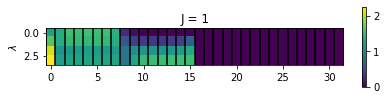

In [6]:
show_params_ising_chain(thetas_arr)

---
## Resources
* [Quantum Convolutional Neural Networks](https://arxiv.org/abs/1810.03787)
* [Machine Learning Phase Transitions with a Quantum Processor](https://arxiv.org/abs/1906.10155)

In [6]:
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import autograd.numpy as anp

In [7]:
def cross_entropy_loss(labels, predictions):
    '''
    f = - Σ [(Yi*log(Pi) + (1 - Yi)*log(1 - Pi) )]  for i in TrainingSet
    '''
    loss = 0
    for l, p in zip(labels, predictions):
        term = ( l * np.log(p) + (1 - l) * np.log(1 - p) )
        loss = loss + term

    return -1 * loss

In [8]:
def cross_entropy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        c_entropy = l * (anp.log(p[l])) + (1 - l) * anp.log(1 - p[1 - l])
        loss = loss + c_entropy

    return -1 * loss

In [12]:
labels = np.array([1,1,0,0])
predictions = np.array([0.5,0.8,0.2,0.01])

In [18]:
labels

tensor([1, 1, 0, 0], requires_grad=True)

In [19]:
predictions

tensor([0.5 , 0.8 , 0.2 , 0.01], requires_grad=True)

In [13]:
cross_entropy_loss(labels, predictions)

tensor(1.14948462, requires_grad=True)

In [14]:
cross_entropy(labels, predictions)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [20]:
data = joblib.load('./params.job')

In [21]:
X_train = np.array(data[0][1])
Y_train = np.array(data[0][2])

for J in range(1,len(data)):
    X_train = np.concatenate((X_train, np.array(data[J][1])))
    Y_train = np.concatenate((Y_train, np.array(data[J][2])))
    
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))

Size of Training Set: 50


In [22]:
Y_train

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1], requires_grad=True)